# Pets Semantic Segmentation
## <font color=navy>Data Processing

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import re
import random
import numpy as np

In [2]:
# For Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Preprocessing

In [3]:
%cd drive/MyDrive/CPE608\ Final\ Project

/content/drive/MyDrive/CPE608 Final Project


In [ ]:
# Download data
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  29.3M      0  0:00:25  0:00:25 --:--:-- 31.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  11.5M      0  0:00:01  0:00:01 --:--:-- 11.6M


In [ ]:
# Unpack data
#!tar -xf data/images.tar.gz -C data/images
#!tar -xf data/annotations.tar.gz -C data/annotations

# Move to data directory
#shutil.move('images.tar.gz', 'data/images.tar.gz')
#shutil.move('annotations.tar.gz', 'data/annotations.tar.gz')

In [ ]:
# Images
images = sorted(
    [os.path.join('data/images/', image) 
    for image in os.listdir('data/images/') if image.endswith('.jpg')])

# Masks
masks = sorted(
    [os.path.join('data/annotations/trimaps/', mask)
    for mask in os.listdir('data/annotations/trimaps/') if mask.endswith('.png')
    and not mask.startswith('.')]
)

In [ ]:
# Confirm download
print('Total number of samples: ', len(masks))
for i in range(5):
  print(images[i], masks[i])

# Confirm that each image has corresponding mask
assert [j.split('/')[-1].replace('.jpg', '') for j in images] == [k.split('/')[-1].replace('.png', '') for k in masks] 

Total number of samples:  7390
data/images/Abyssinian_1.jpg data/annotations/trimaps/Abyssinian_1.png
data/images/Abyssinian_10.jpg data/annotations/trimaps/Abyssinian_10.png
data/images/Abyssinian_100.jpg data/annotations/trimaps/Abyssinian_100.png
data/images/Abyssinian_101.jpg data/annotations/trimaps/Abyssinian_101.png
data/images/Abyssinian_102.jpg data/annotations/trimaps/Abyssinian_102.png


(480, 351, 3)


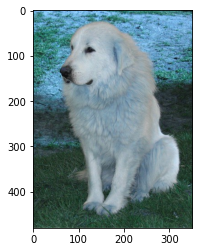

(480, 351, 3)


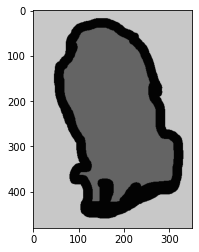

In [ ]:
# Display test input image and corresponding ground truth mask
img = cv2.imread(images[4200])
plt.imshow(img)
print(img.shape)

plt.show()

mask = cv2.imread(masks[4200])
print(mask.shape)
mask[mask == 1] = 100
mask[mask == 2] = 200
plt.imshow(mask)
plt.show()

### Data Sampling

In [ ]:
# Get dog and cat breed lists
breeds = [i.split('/')[-1].replace('.jpg', '') for i in images]
breeds = set([re.sub(r'_[0-9]+', '', b) for b in breeds])
dogs = [b for b in breeds if b[0].islower()] # Dog photos start with lowercase letters
cats = [b for b in breeds if b[0].isupper()] # Cat photos start with uppercase letters

In [ ]:
# Report lengths; confirm with official source
assert len(dogs) == 25
assert len(cats) == 12

In [ ]:
# Get indices of cats and dogs
dog_ind = [i for i in range(len(images)) if any(d in images[i] for d in dogs)]
cat_ind = [i for i in range(len(images)) if any(c in images[i] for c in cats)]

# Confirm no overlap
assert len(set(dog_ind).intersection(set(cat_ind))) == 0

In [ ]:
# Confirm sample quantity
print('Number of Dog Samples: ', len(dog_ind))
print('Number of Cat Samples: ', len(cat_ind))

assert len(dog_ind) + len(cat_ind) == len(images)

Number of Dog Samples:  4990
Number of Cat Samples:  2400


In [ ]:
''' Train/Test/Validation Split Function '''
def train_test_val(data):
    # Randomly sample 20% of values for validation/test sets
    val = random.sample(data, int(len(data)*0.2))
    
    # Get 80% for training
    train = list(set(data) - set(val))
    
    # Get 10% for testing
    test = random.sample(val, int(len(val)*0.5))
    val = list(set(val) - set(test))
    
    return train, test, val

In [ ]:
# Train/Test/Split dog and cats data separately
# - This will sample proportionally to image imbalance
dog_train, dog_test, dog_val = train_test_val(dog_ind)
cat_train, cat_test, cat_val = train_test_val(cat_ind)

# Report values
print('Number of Dog Training Samples: ', len(dog_train))
print('Number of Dog Testing Samples: ', len(dog_test))
print('Number of Dog Validation Samples: ', len(dog_val))
assert len(dog_train + dog_test + dog_val) == len(dog_ind)
print()
print('Number of Cat Training Samples: ', len(cat_train))
print('Number of Cat Testing Samples: ', len(cat_test))
print('Number of Cat Validation Samples: ', len(cat_val))
assert len(cat_train + cat_test + cat_val) == len(cat_ind)
print()

# Combine splits
train_ind = dog_train + cat_train
test_ind = dog_test + cat_test
val_ind = dog_val + cat_val

# Report values
print('Number of Training Samples: ', len(train_ind))
print('Number of Testing Samples: ', len(test_ind))
print('Number of Validation Samples: ', len(val_ind))
assert len(train_ind + test_ind + val_ind) == len(images)

Number of Dog Training Samples:  3992
Number of Dog Testing Samples:  499
Number of Dog Validation Samples:  499

Number of Cat Training Samples:  1920
Number of Cat Testing Samples:  240
Number of Cat Validation Samples:  240

Number of Training Samples:  5912
Number of Testing Samples:  739
Number of Validation Samples:  739


In [ ]:
# Split images and masks
train_img = [images[i] for i in train_ind]
train_masks = [masks[i] for i in train_ind]
assert len(train_img) == len(train_masks)

test_img = [images[i] for i in test_ind]
test_masks = [masks[i] for i in test_ind]
assert len(test_img) == len(test_masks)

val_img = [images[i] for i in val_ind]
val_masks = [masks[i] for i in val_ind]
assert len(val_img) == len(val_masks)

In [ ]:
# Confirm image -> mask correspondence did not get invalidated
print(train_img[222])
print(train_masks[222])
print()
print(test_img[222])
print(test_masks[222])
print()
print(val_img[222])
print(val_masks[222])

data/images/american_pit_bull_terrier_174.jpg
data/annotations/trimaps/american_pit_bull_terrier_174.png

data/images/american_bulldog_221.jpg
data/annotations/trimaps/american_bulldog_221.png

data/images/wheaten_terrier_150.jpg
data/annotations/trimaps/wheaten_terrier_150.png


### Data Packaging

In [ ]:
# Write lists of data split to files
np.save('data/train_img.npy', np.array(train_img))
np.save('data/train_masks.npy', np.array(train_masks))
np.save('data/test_img.npy', np.array(test_img))
np.save('data/test_masks.npy', np.array(test_masks))
np.save('data/val_img.npy', np.array(val_img))
np.save('data/val_masks.npy', np.array(val_masks))

### Data Consolidation

In [5]:
# Load data files
train_img = np.load('data/train_img.npy')
train_masks = np.load('data/train_masks.npy')
test_img = np.load('data/test_img.npy')
test_masks = np.load('data/test_masks.npy')
val_img = np.load('data/val_img.npy')
val_masks = np.load('data/val_masks.npy')

In [6]:
train_img

array(['data/images/american_bulldog_10.jpg',
       'data/images/american_bulldog_100.jpg',
       'data/images/american_bulldog_102.jpg', ...,
       'data/images/Sphynx_96.jpg', 'data/images/Sphynx_98.jpg',
       'data/images/Sphynx_99.jpg'], dtype='<U46')

In [7]:
# Create NumPy array of given dataset
def create_array(files):
  # Initialize array
  imgs = []

  for i in files:
    # Read image as array
    img = cv2.imread(i)

    # Resize
    img = cv2.resize(img, (160, 160))

    # Add array to list
    imgs.append(img)
  
  # Return stacked array
  return np.stack(imgs)

In [8]:
n = create_array(train_img)

KeyboardInterrupt: ignored